read info.json

In [5]:
import json
import os
f = 'B075X65R3X/info.json'
with open(f, 'r') as file:
    data = json.load(file)

# Access the data
data

{'backend': 'CYCLES',
 'light_mode': 'uniform',
 'fast_mode': False,
 'format_version': 6,
 'channels': ['R', 'G', 'B', 'A', 'D'],
 'scale': 0.5,
 'images': [{'intrinsic': [[711.1110599640117, 0.0, 256.0],
    [0.0, 711.1110599640117, 256.0],
    [0.0, 0.0, 1.0]],
   'pose': [[-0.8608624339103699,
     -0.3795045018196106,
     0.3389574885368347,
     0.6779149174690247],
    [0.5088377594947815,
     -0.6420537829399109,
     0.5734554529190063,
     1.1469107866287231],
    [1.093386803319163e-08,
     0.666140615940094,
     0.7458261847496033,
     1.491652488708496],
    [0.0, 0.0, 0.0, 1.0]],
   'rgb': '00000_rgb.png',
   'depth': '00000_depth.png',
   'alpha': '00000_alpha.png',
   'max_depth': 5.0,
   'HW': [512, 512]},
  {'intrinsic': [[711.1110599640117, 0.0, 256.0],
    [0.0, 711.1110599640117, 256.0],
    [0.0, 0.0, 1.0]],
   'pose': [[-0.7480717301368713,
     0.21397116780281067,
     0.6281759738922119,
     1.2563519477844238],
    [0.6636179089546204,
     0.241201877

In [61]:
import numpy as np
import collections
import struct
import math

CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])
CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model)
                         for camera_model in CAMERA_MODELS])
CAMERA_MODEL_NAMES = dict([(camera_model.model_name, camera_model)
                           for camera_model in CAMERA_MODELS])

def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = np.array([
        [Rxx - Ryy - Rzz, 0, 0, 0],
        [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
        [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
        [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz]]) / 3.0
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec

class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)

def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

def read_intrinsics_text(path):
    """
    Taken from https://github.com/colmap/colmap/blob/dev/scripts/python/read_write_model.py
    """
    cameras = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                camera_id = int(elems[0])
                model = elems[1]
                # assert model == "PINHOLE", "While the loader support other types, the rest of the code assumes PINHOLE"
                width = int(elems[2])
                height = int(elems[3])
                params = np.array(tuple(map(float, elems[4:])))
                cameras[camera_id] = Camera(id=camera_id, model=model,
                                            width=width, height=height,
                                            params=params)
    return cameras

def read_extrinsics_text(path):
    """
    Taken from https://github.com/colmap/colmap/blob/dev/scripts/python/read_write_model.py
    """
    images = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                image_id = int(elems[0])
                qvec = np.array(tuple(map(float, elems[1:5])))
                tvec = np.array(tuple(map(float, elems[5:8])))
                camera_id = int(elems[8])
                image_name = elems[9]
                elems = fid.readline().split()
                xys = np.column_stack([tuple(map(float, elems[0::3])),
                                       tuple(map(float, elems[1::3]))])
                point3D_ids = np.array(tuple(map(int, elems[2::3])))
                images[image_id] = Image(
                    id=image_id, qvec=qvec, tvec=tvec,
                    camera_id=camera_id, name=image_name,
                    xys=xys, point3D_ids=point3D_ids)
    return images
    
def intr_from_pinhole_camera(camera):
    if camera.model=='SIMPLE_PINHOLE':
        # https://github.com/colmap/colmap/blob/main/src/colmap/sensor/models.h#L250-L256
        f, cx, cy =  camera.params
        fx = fy = f
    elif camera.model=='PINHOLE':
        # https://github.com/colmap/colmap/blob/main/src/colmap/sensor/models.h#L265-L271
        fx, fy, cx, cy =  camera.params
    return np.array([
                [fx, 0, camera.width/2],
                [0, fy, camera.height/2],
                [0, 0, 1]
            ]).tolist()

def hw_from_pinhole_camera(camera):
    return [camera.height, camera.width]

def extr_from_image(image):
    R = image.qvec2rotmat()
    t = np.array(image.tvec)
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = R.transpose()
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0 
    return Rt.tolist()

In [63]:
path = 'aparecida5'
cameras_extrinsic_file = os.path.join(path, "sparse/0", "images.txt")
cam_extrinsics = read_extrinsics_text(cameras_extrinsic_file)

cameras_intrinsic_file = os.path.join(path, "sparse/0", "cameras.txt")
cam_intrinsics = read_intrinsics_text(cameras_intrinsic_file)

images_list = []
for k, v in cam_extrinsics.items():
    pose = extr_from_image(v)
    image = {
        'intrinsic':intr_from_pinhole_camera(cam_intrinsics[v.camera_id]),
        'pose': pose,
        'HW': hw_from_pinhole_camera(cam_intrinsics[v.camera_id]) }
    images_list.append( image )
# cam_extrinsics
cam_extrinsics

{1: Image(id=1, qvec=array([ 0.99887792, -0.0129593 ,  0.03826974, -0.02470593]), tvec=array([-1.61229348, -0.20723563,  2.18756859]), camera_id=1, name='20250105_164818.jpg', xys=array([[3794.08129883,    4.91670752],
        [3794.08129883,    4.91670752],
        [  65.73661041,   19.34813881],
        ...,
        [1472.27661133, 1167.29333496],
        [3781.79052734, 1140.13598633],
        [2690.58740234, 1534.77185059]]), point3D_ids=array([  -1,   -1,   -1, ...,   -1,   -1, 2490])),
 2: Image(id=2, qvec=array([ 0.9925519 ,  0.08399517, -0.03659143,  0.08029081]), tvec=array([-1.80931678, -0.32511188,  3.51023525]), camera_id=1, name='20250105_164835.jpg', xys=array([[1.05630542e+03, 3.04900765e+00],
        [1.06357837e+03, 3.06640649e+00],
        [1.56434509e+03, 5.13650608e+00],
        ...,
        [1.55971777e+03, 5.49968140e+02],
        [3.39619019e+03, 1.11845935e+03],
        [3.39619019e+03, 1.11845935e+03]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1])),
 3: Im

In [ ]:
"""
Script to parse the generated files into our desirable format
"""
import argparse
import json
import math
import os
import random
import sys
import glob
from PIL import Image
import numpy as np
import pdb

def main():

    parser = argparse.ArgumentParser()
    parser.add_argument("--input_path", required=True, type=str)
    parser.add_argument("--output_path", required=True, type=str)
    args = parser.parse_args()
    
    input_path = args.input_path
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)
    info = json.load(open(os.path.join(input_path, 'info.json')))
    
    object = dict(images=[])
    num_images = len(glob.glob(f'{input_path}/*[0-9].json'))
    for i in range(num_images):
        camera_metadata = json.load(open(os.path.join(input_path, f"{i:05}.json")))
        channels = [np.array(Image.open(os.path.join(input_path, f"{i:05}_{c}.png"))) / (2**16-1) for c in ['r', 'g', 'b', 'a', 'depth']]
        
        # mapping to [0,255]
        rgb = np.uint8(np.stack(channels[:3], axis=-1) * 255)
        mask = np.uint8(channels[3] * 255)
        depth = np.uint8(channels[-1] * 255)

        # merge image
        Image.fromarray(rgb).convert('RGB').save(os.path.join(output_path, f'{i:05}_rgb.png'))
        Image.fromarray(depth).save(os.path.join(output_path, f'{i:05}_depth.png'))
        Image.fromarray(mask).save(os.path.join(output_path, f'{i:05}_alpha.png'))

        # intrinsic
        x_fov, y_fov = camera_metadata['x_fov'], camera_metadata['y_fov']
        width, height = rgb.shape[:2]
        fx = 1 / np.tan(x_fov / 2) * (width / 2)
        fy = 1 / np.tan(y_fov / 2) * (height / 2)
        intrinsic = np.array([
            [fx, 0, width/2],
            [0, fy, height/2],
            [0, 0, 1]
        ])

        """
            OpenGL (X right; Y up; Z inward) 
        """

        # write extrinsic from opencv camera
        origin = np.array(camera_metadata['origin']).reshape(-1,1) # origin
        right = np.array(camera_metadata['x']).reshape(-1,1)  # right vector
        down = np.array(camera_metadata['y']).reshape(-1,1)   # down vector
        lookat = np.array(camera_metadata['z']).reshape(-1,1) # forward vector

        pose = np.block([
                [right, -down,  -lookat,  origin],
                [0., 0., 0., 1.]]
            )

        image = dict(
            intrinsic= intrinsic.tolist(),
            pose = pose.tolist(),
            rgb=os.path.join(f'{i:05}_rgb.png'),
            depth=os.path.join(f'{i:05}_depth.png'),
            alpha=os.path.join(f'{i:05}_alpha.png'),
            max_depth = camera_metadata['max_depth'],
            HW = [height, width],
        )

        object['images'].append(image)
        object['bbox'] = camera_metadata['bbox'] 

    with open(os.path.join(output_path, 'info.json'), "w") as f:
        object = {**info, **object}
        json.dump(object, f)

main()

Text(0.5, 1.0, 'depth map')

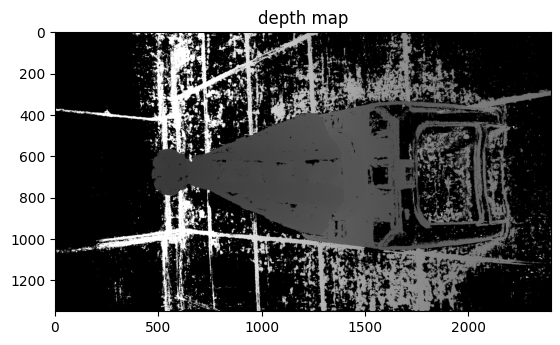

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(
            fid, delimiter="&", max_rows=1, usecols=(0, 1, 2), dtype=int
        )
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()

depth_map = read_array(r"d:\Diego\GS\data\aparecida\dense\0\stereo\depth_maps\20250105_164818.jpg.geometric.bin")
min_depth, max_depth = np.percentile(
        depth_map, [5, 95]
    )
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth


# Visualize the depth map.
plt.figure()
plt.imshow(depth_map,cmap='gray')
plt.title("depth map")
